<a href="https://colab.research.google.com/github/Sudhi162/Cambridge_Real_Estate_Analysis/blob/main/CambridgeHomePricesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cambridge Real Estate Analysis**

Cambridge is a centre of innovation in Greated boston area. Many Enterpreuners have made this are home to their successfull businesses and Technology companies 
and start ups are thriving in this area. Partly because of the availability of high skilled labor and aspiring new grads entering work force in greater boston area. 
Cambridge is also home to thousands of families living in this neighborhood for decades and centuries. 


This project aims to analyse the Real estate in Cambridge MA and answer below questions - 
1. How does the Property Value distribution look like in Cambridge for different property types. 
2. What was the sales volume in this area in last 10 years for different property types. 
3. Distribution of gap between sale price and assessed value for different property types in last 10 years sales.
4. Develop and evaluate a Machine learning model to predict future property sale prices in cambridge area.

# Importing the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Importing the dataset

In [2]:
dataset = pd.read_csv('Cambridge_Property_Database_FY2016-FY2021.csv')

## 1. How does the Property Value distribution look like in Cambridge for different property types?

## Distribution of accessed property values for different types of properties

In [3]:
# Create a subset of the Raw Data set to calculate the mean, median and standard deviations of assessed value based on different property types

ValueDistPropertyTypeall = dataset[['PropertyType','AssessedValue']]
ValueDistPropertyType = ValueDistPropertyTypeall[ValueDistPropertyTypeall['AssessedValue'] != 0]
ValueDistPropertyType_pivots = ValueDistPropertyType.pivot_table(index='PropertyType', values= 'AssessedValue',aggfunc=[np.max,np.min,np.mean,np.median,np.std])
ValueDistPropertyType_pivots.round(2)
cm = sns.light_palette("green", as_cmap=True)
ValueDistPropertyType_pivots_style=ValueDistPropertyType_pivots.style.background_gradient(cmap=cm)
ValueDistPropertyType_pivots_style.format('${:,.2f}')

,amax,amin,mean,median,std
,AssessedValue,AssessedValue,AssessedValue,AssessedValue,AssessedValue
PropertyType,,,,,
Apartment Building,"$238,069,800.00","$120,000.00","$7,578,745.95","$2,172,400.00","$20,056,022.80"
Business Premise,"$568,562,000.00",$300.00,"$21,167,765.81","$2,176,950.00","$53,461,305.17"
Church/Religious,"$33,792,600.00","$44,700.00","$5,096,612.38","$2,017,800.00","$6,652,210.19"
Condominium,"$198,203,900.00","$3,200.00","$735,026.46","$606,700.00","$2,225,444.21"
Educational,"$1,615,000,000.00","$19,000.00","$286,690,561.23","$24,776,900.00","$497,326,890.09"
Family Home,"$159,838,700.00","$69,000.00","$1,615,626.18","$1,218,800.00","$3,211,264.30"
Hospital,"$184,797,600.00","$572,500.00","$24,050,110.20","$6,752,000.00","$45,942,735.97"
Land,"$125,271,700.00","$1,000.00","$1,443,188.63","$189,600.00","$6,005,182.77"


# Distribution plot for Property Assessed value

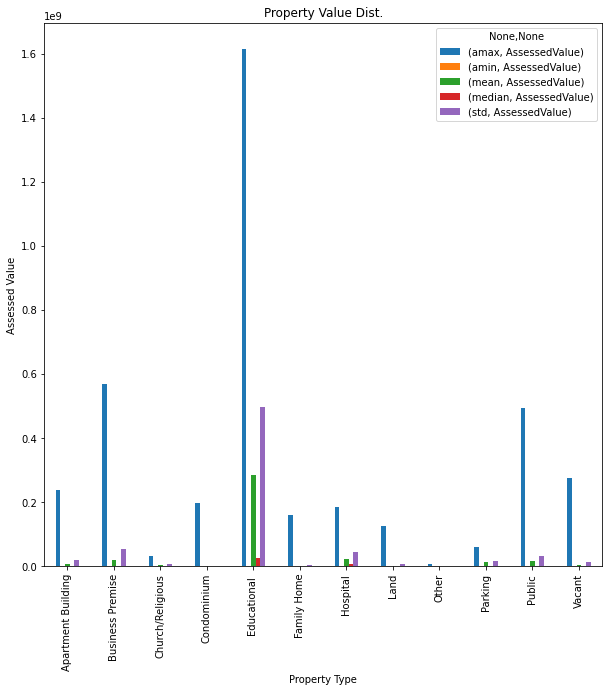

In [4]:
ValueDistPropertyType_pivots.plot(xlabel= 'Property Type', ylabel = 'Assessed Value',use_index = True, kind = 'bar', title='Property Value Dist.',figsize=[10,10]);

**Observation** - Educational institutions have a high distrubution of assessed property value. The mean for a Business premise was 21MM and for a condominium the mean was 735k USD.Also notably depending on the premium property features sometimes may take to pay upto 2MM USD more than mean price for a condominium in Cambridge area as std for condominiums is 2.2 MM!

# 2. What was the sales volume in this area in last 10 years for different property types.

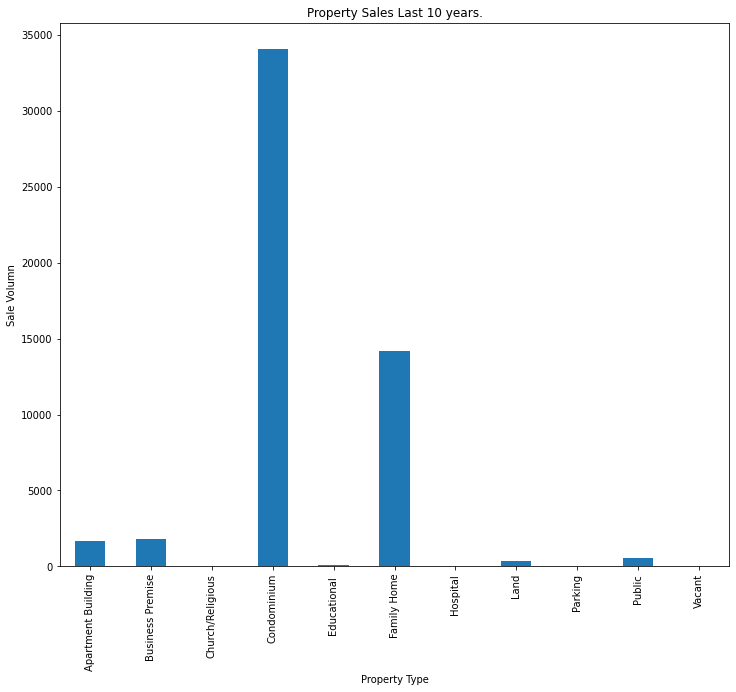

In [5]:
# Create a subset of the raw data to determine the sales volume of different property types in last 10 years

SalesDataset = dataset.loc[:,['PID','PropertyType','SalePrice','SaleDate']]
SalesDataset.loc[:,'SaleDate'] = pd.to_datetime(SalesDataset.loc[:,'SaleDate'],errors='coerce', format='%m/%d/%Y')
SalesDatasetFiltered = SalesDataset.loc[(SalesDataset.loc[:,'SaleDate'] >= '2011-04-01'),:]
SalesDatasetAgg = SalesDatasetFiltered.groupby(['PropertyType'])['PID'].count()
SalesDatasetAgg.plot(xlabel= 'Property Type', ylabel = 'Sale Volumn',use_index = True, kind = 'bar', title='Property Sales Last 10 years.',figsize=[12,10]);

**Observation** - In the last 10 years condiminum properties have been outselling Family homes and other business premises in Cambridge area.

# 3. How does the Distribution of price gap between sale price and assessed value look?

In [6]:
'''Here a subset of the raw data file is taken for last 10 years and a new column is calculated 
   to plot the price gap measured between the assessed value and the sale price of the property for different property types'''

SalesDataset = dataset.loc[:,['PID','PropertyType','AssessedValue','SalePrice','SaleDate']]
SalesDataset.loc[:,'SaleDate'] = pd.to_datetime(SalesDataset.loc[:,'SaleDate'],errors='coerce', format='%m/%d/%Y')
SalesDatasetFiltered = SalesDataset.loc[(SalesDataset.loc[:,'SaleDate'] >= '2011-04-01'),:]
SalesDatasetRemoveZeroAsdVal = SalesDatasetFiltered.loc[(SalesDatasetFiltered.loc[:,'AssessedValue'] > 0),:]
SalesDatasetRemoveZeroSaleVal = SalesDatasetRemoveZeroAsdVal.loc[(SalesDatasetRemoveZeroAsdVal.loc[:,'SalePrice'] > 0),:]
SalesDatasetRemoveZeroSaleVal.insert(4,"PriceGap",SalesDatasetRemoveZeroSaleVal['SalePrice']-SalesDatasetRemoveZeroSaleVal['AssessedValue'])
SalesDatasetRemoveNegPriceGap = SalesDatasetRemoveZeroSaleVal.loc[(SalesDatasetRemoveZeroSaleVal.loc[:,'PriceGap'] > 0),:]
SalesDatasetRemoveNegPriceGap_pivots = SalesDatasetRemoveNegPriceGap.pivot_table(index='PropertyType', values= 'PriceGap',aggfunc=[np.max,np.min,np.mean,np.median,np.std])
SalesDatasetRemoveNegPriceGap_pivots.round(2)
cm = sns.light_palette("green", as_cmap=True)
SalesDatasetRemoveNegPriceGap_pivots_style=SalesDatasetRemoveNegPriceGap_pivots.style.background_gradient(cmap=cm)
SalesDatasetRemoveNegPriceGap_pivots_style.format('${:,.2f}')

,amax,amin,mean,median,std
,PriceGap,PriceGap,PriceGap,PriceGap,PriceGap
Apartment Building,"$43,572,800.00",$200.00,"$4,677,977.02","$1,263,550.00","$6,933,385.62"
Business Premise,"$501,070,900.00","$2,200.00","$40,723,330.90","$3,781,300.00","$100,980,911.61"
Church/Religious,"$50,900.00","$50,900.00","$50,900.00","$50,900.00",$nan
Condominium,"$539,488,699.00",$100.00,"$303,705.63","$52,325.00","$7,371,982.77"
Educational,"$15,845,900.00","$1,704,325.00","$8,622,652.84","$7,936,198.00","$5,933,071.52"
Family Home,"$1,398,780,200.00",$100.00,"$1,785,578.40","$143,000.00","$36,727,918.77"
Hospital,"$399,600.00","$32,900.00","$210,375.00","$204,500.00","$150,601.34"
Land,"$554,892,900.00","$4,400.00","$50,859,760.81","$2,307,250.00","$112,623,584.00"
Parking,"$123,953,600.00","$1,000.00","$30,632,101.00","$528,000.00","$48,006,825.38"


# Distribution plot for PriceGap Analysis

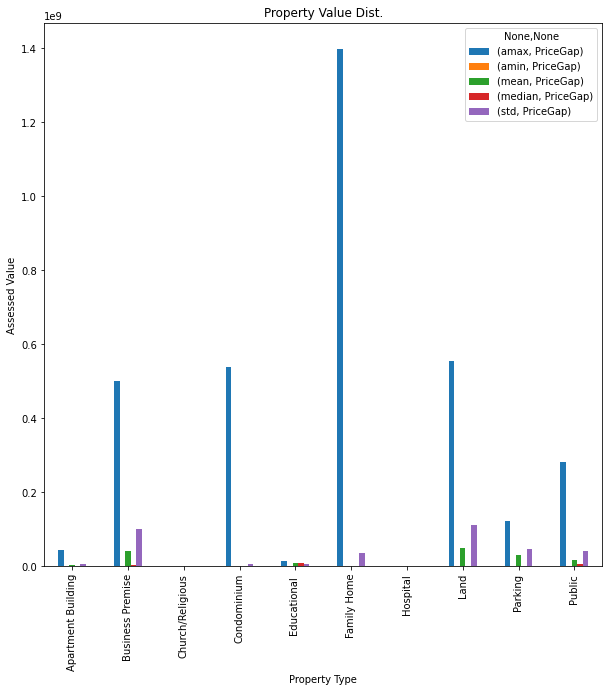

In [7]:
SalesDatasetRemoveNegPriceGap_pivots.plot(xlabel= 'Property Type', ylabel = 'Assessed Value',use_index = True, kind = 'bar', title='Property Value Dist.',figsize=[10,10]);

**Observation** - Family Homes, Business premises, Piece of Land and Educational properties have sold for much more than the last assessed value.

# 4. Develop and evaluate a Machine learning model to predict future property sale prices in cambridge area.

In [8]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [9]:
def train_test_linear_model(dataset, dataset_cols, col_predicted, dummy_na):

  '''
    INPUT:
    dataset - pandas dataframe with categorical variables you want use for train test    
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    lm_model - liner model that can be used to make predictions
    test_score
    train_score
    '''
  
  df = pd.read_csv(dataset)

  #Only use quant variables and drop any rows with missing values
  num_vars = df[dataset_cols]

  #Drop the rows with missing salaries
  ''' Note: here the missing values are dropped from the dataset instead of imputing them . The reason to do so is to avoid imputing values for the value that will be determined by the Linear model. 
  Hence instead of imputing missing values for the column that will be predicted, this function drops any missing values.
  Also , once the model is available and optimised the missing values of sale price can be determined or predicted using the Linear model itself instead of imputing.
  '''

  drop_sal_df = num_vars.dropna(subset=[col_predicted], axis=0)
  cat_df = drop_sal_df.select_dtypes(include=['object'])

  cat_cols_lst=cat_df.columns
  df_new = create_dummy_df(drop_sal_df, cat_cols_lst, dummy_na=False) #Use your newly created function

  fill_mean = lambda col: col.fillna(col.mean())
  # Fill the mean
  fill_df_new = df_new.apply(fill_mean, axis=0)

  #Split into explanatory and response variables
  X = fill_df_new.drop(col_predicted, axis=1)
  y = fill_df_new[col_predicted]

  #Split into train and test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

  lm_model = LinearRegression(normalize=True) # Instantiate
  lm_model.fit(X_train, y_train) #Fit

  #Predict using your model
  y_test_preds = lm_model.predict(X_test)
  y_train_preds = lm_model.predict(X_train)

  #Score using your model
  test_score = r2_score(y_test, y_test_preds)
  train_score = r2_score(y_train, y_train_preds)

  return lm_model, test_score,train_score

In [10]:
# Train the Linear Model 
dataset_cols = ['PropertyType', 'LandArea', 'YearOfAssessment', 'BuildingValue', 'LandValue', 'AssessedValue',  'UnfinishedBasementGross', 'FinishedBasementGross', 'SalePrice']
col_predicted = 'SalePrice'
lm_mdl, test_scr ,train_scr = train_test_linear_model('Cambridge_Property_Database_FY2016-FY2021.csv',dataset_cols,col_predicted,False)

#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(test_scr, train_scr))

The rsquared on the training data was 0.7728227272923986.  The rsquared on the test data was 0.8168455230295527.


**Observation** - The rsquared on the training data was 0.7728227272923986.  The rsquared on the test data was 0.8168455230295527. 